In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from lr_utils import load_dataset

%matplotlib inline

In [2]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

In [3]:
# for training dataset we have 209 images, 64x64 pixels and 3 color channels RGB
train_set_x_orig.shape

(209, 64, 64, 3)

y = [0], it's a 'non-cat' picture.


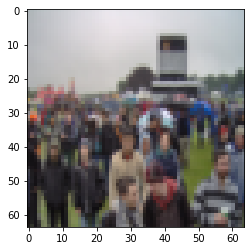

In [4]:
# Example of a picture
index = 100
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

A trick when you want to flatten a matrix X of shape (a,b,c,d) to a matrix X_flatten of shape (b$*$c$*$d, a) is to use: 
```python
X_flatten = X.reshape(X.shape[0], -1).T      # X.T is the transpose of X
```

In [5]:
# we need to reshape/flatten the picture RGB values to have
# each column will represent the observation with flatten RGB values, 64*64*3

train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

In [6]:
train_set_x_flatten.shape # we see that the shape is proper

(12288, 209)

In [7]:
test_set_x_flatten.shape

(12288, 50)

In [8]:
# standarization of dataset
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

## Mathematical architecture of the algorithm

For each iteration (to find the best values of weights for NN) we need to calculate both steps forward and backward propagation. 

- Forward propagation is starting with our observations and weights' values and ends with calculating loss function
- Backward propagation uses derivatives calculation to update the weights according the cost function decrease directions.

This happens for one observation. If we have sample of size $m$, then we divide gradient by $m$ and also instead of calculating loss, we calculate cost function which is average loss.

Assume we are considering $n$ features. Given $x^{(i)} = (x_{1i}, x_{2i}, \dots, x_{1n})^{T}$ which is one example out of $m$ in our training sample we have:
    
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$


The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

### PROPAGATE STEP

***Forward step***

1) Get $X = [x^{(1)}, x^{(2)}, \dots, x^{(m)}]$ as an input

2) For given $w$ and $b$ from the previous iteration (or intialized at the first iteration) calculate $A = \sigma(w^TX + b) = (a^{(1)}, a^{(2)}, \dots, a^{(m)})$

3) Calculate  $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$



***Backward step***

Calculate gradient for $w$ and $b$ using all $m$ observations:

$\frac{\partial d J}{\partial w} = \frac{1}{m}X(A-Y)^T$
$\frac{\partial d J}{\partial b} = \frac{1}{m}\sum_{i=1}^{m}(a^{(i)} - y^{(i)})$

### OPTIMIZE STEP

Update parameters using gradient descent. For any parameter $\theta$:
$\theta = \theta - \alpha d \theta$, where $\alpha$ is learning rate.

### PREDICT STEP

When the $w$ and $b$ are estimated, calculate the final prediction by applying:

$\hat{Y} = A = \sigma(w^T X + b)$

and if the value is >= 0.5 then assign value 1, 0 otherwise.


In [41]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    
    s = 1/(1+np.exp(-z))
    
    return s

In [38]:
def propagate(w, b, X, Y):
    """
    Calculates forward propagation step - cost function, backward propagation step - gradient to be used to find the parameters minimizing cost function
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)
    
    Returns:
    cost -- negative log-likelihood cost for logistic regression (binary cross-entropy)
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    """
    
    m = X.shape[1]
    #forward propagation (cost of the function)
    A = sigmoid(np.dot(w.T, X) + b)
    cost = -np.sum(Y*np.log(A) + (1-Y)*(np.log(1-A)))/m
    
    #backward propagation (gradient)
    dw = np.dot(X, (A-Y).T)/m
    db = np.sum(A - Y)/m
    
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [39]:
# example
w, b, X, Y = np.array([[1.],[2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]), np.array([[1,0,1]])

For an example above let's take last column of $X$ array. If we take $w$ and multiply coordinate-wise we should get exactly the same as an output. Because $X$ is a matrix, then we will get an array of dot products with the size (1, number of examples).

In [33]:
np.dot(w.T, X[:, 2])

array([-7.4])

In [35]:
np.dot(w.T, X).shape

(1, 3)

In [42]:
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[0.99845601]
 [2.39507239]]
db = 0.001455578136784208
cost = 5.801545319394553


In [87]:
def optimize(w, b, X, Y, learning_rate, num_of_iterations, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    learning_rate -- learning rate of the gradient descent update rule
    num_of_iterations -- number of iterations of the optimization loop
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    """
    
    costs = []
    
    for i in range(num_of_iterations):
        grads, cost = propagate(w, b, X, Y)
        
        dw = grads["dw"]
        db = grads["db"]
        
        w = w - learning_rate*dw
        b = b - learning_rate*db
        
        costs.append(cost)
        
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
            
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [88]:
params, grads, costs = optimize(w, b, X, Y, num_of_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[0.19033591]
 [0.12259159]]
b = 1.9253598300845747
dw = [[0.67752042]
 [1.41625495]]
db = 0.21919450454067657


In [89]:
def predict(w, b, X):
    """
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b), cutoff 0.5
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    """
    
    probabilities = sigmoid(np.dot(w.T, X) + b)
    
    return np.round(probabilities) #to return classes 1 or 0

In [90]:
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    
    w = np.zeros((dim,1), dtype=float)
    b = 0

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

In [93]:
def model(X_train, Y_train, X_test, Y_test, num_iterations, learning_rate, verbose):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    verbose -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    m = X_train.shape[1]
    # initializing parameters
    w, b = initialize_with_zeros(m)
    
    # optimizing
    params, grads, costs = optimize(w, b, X_train, Y_train, learning_rate = 0.001, num_of_iterations = num_iterations)
    
    w = params["w"]
    b = params["b"]
    
    # predicting
    test_prediction = predict(w, b, X_test)
    train_prediction = predict(w, b, X_train)
    
    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(train_prediction - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(test_prediction - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d
    

In [94]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, verbose = True)

ValueError: shapes (1,209) and (12288,209) not aligned: 209 (dim 1) != 12288 (dim 0)